In [1]:
import pandas as pd

# Read data of 2019-2021
df = pd.read_csv('data/slcp_2019-2021_raw.csv', index_col=0, parse_dates=True)
metdata = pd.read_csv('data/metdata_2019-2021.csv', index_col=0, parse_dates=True)

df = df.join(metdata)

# Replace BC values with calibeated values
df.rename(columns={'BC': 'BC1h'}, inplace=True)
bc10m = pd.read_csv('data/BC10m2.csv', index_col=0, parse_dates=True)
bc10m = bc10m[['BC']]
bc10m = bc10m.resample('H').mean()
df = pd.concat([df, bc10m], axis=1)
df.head()

,BC1h,O3,PM2.5,MERRA2-BC,wdir,wspd,temp,prec,BC
2019-01-01 00:00:00,2.45,16.29,29.85,1.924800,NaN,NaN,NaN,NaN,2.883333
2019-01-01 01:00:00,2.48,14.59,32.77,1.732079,337.5,3.0,11.8,0.0,2.685000
2019-01-01 02:00:00,1.81,15.10,30.55,1.568879,0.0,3.0,11.0,0.0,1.880000
2019-01-01 03:00:00,1.93,15.69,27.14,1.451226,0.0,3.0,11.0,0.0,1.531667
2019-01-01 04:00:00,3.00,16.77,32.37,1.371665,0.0,3.0,11.0,0.0,2.861667


In [2]:
# Normalize data
df = df.dropna()
using_cols = ['PM2.5', 'BC', 'wspd', 'temp', 'prec']
for col in using_cols:
    df[col] = (df[col] - df[col].mean()) / df[col].std()

[-0.00810039 -0.07995067  0.09635884  0.6968808 ]
PearsonRResult(statistic=0.7072361097073371, pvalue=0.0)


<Axes: >

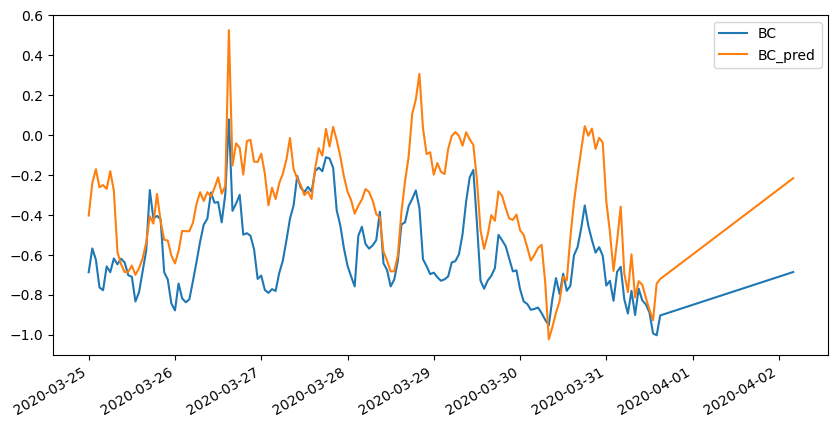

In [3]:
# df = df.dropna()

from sklearn import linear_model
from scipy.stats import pearsonr
from matplotlib import pyplot as plt

X = df[['prec', 'wspd', 'temp', 'PM2.5']]
y = df['BC']
regr = linear_model.LinearRegression()
regr = regr.fit(X, y)
print(regr.coef_)
df['BC_pred'] = regr.predict(X)
print(pearsonr(df['BC'], df['BC_pred']))

plot_cols = ['BC', 'BC_pred']
select_period = df.loc['2020-03-25':'2020-04-25']
select_period[plot_cols].plot(figsize=(10,5))


In [4]:
test_predict_BC = regr.predict([[0, 6, 35, 30]])
print(test_predict_BC)

[23.79927933]


c:\Users\photo\miniconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


DJF
[ 0.01067767  0.02868016 -0.03575085  0.03681638]


C:\Users\photo\AppData\Local\Temp\ipykernel_13044\4061654280.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['BC_pred'] = regr.predict(X)


PearsonRResult(statistic=0.7144661071980198, pvalue=0.0)
MAM
[-0.00764384 -0.01444579  0.01454559  0.03241878]


C:\Users\photo\AppData\Local\Temp\ipykernel_13044\4061654280.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['BC_pred'] = regr.predict(X)


PearsonRResult(statistic=0.6556555543597479, pvalue=0.0)
JJA
[-0.00458854 -0.01962448  0.06312709  0.05559964]
PearsonRResult(statistic=0.5584115930145559, pvalue=2.000407925031356e-95)
SON


C:\Users\photo\AppData\Local\Temp\ipykernel_13044\4061654280.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['BC_pred'] = regr.predict(X)


[-0.01012393 -0.12974227  0.04740476  0.05495242]


C:\Users\photo\AppData\Local\Temp\ipykernel_13044\4061654280.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['BC_pred'] = regr.predict(X)


PearsonRResult(statistic=0.7783168918837724, pvalue=0.0)


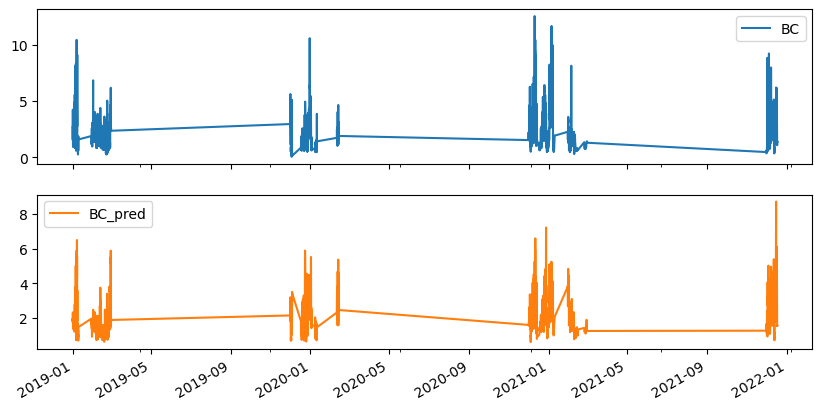

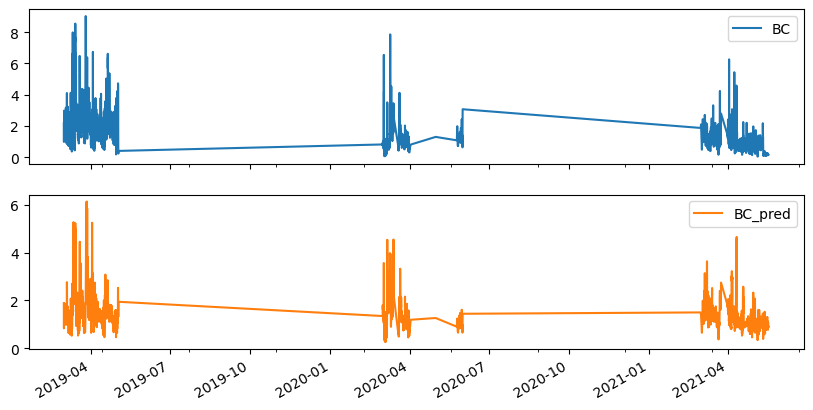

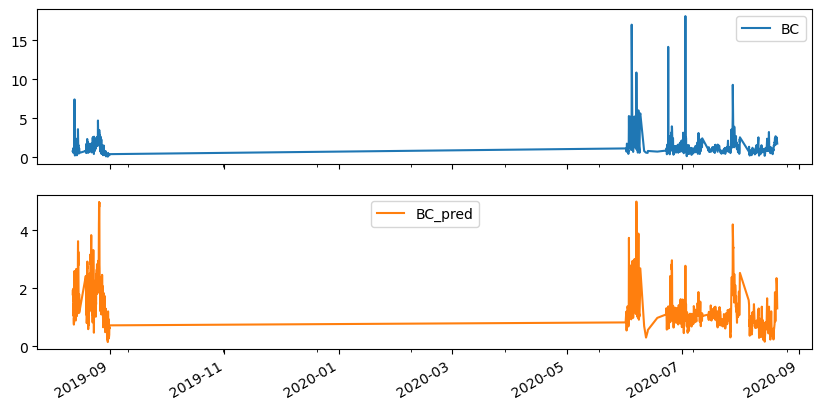

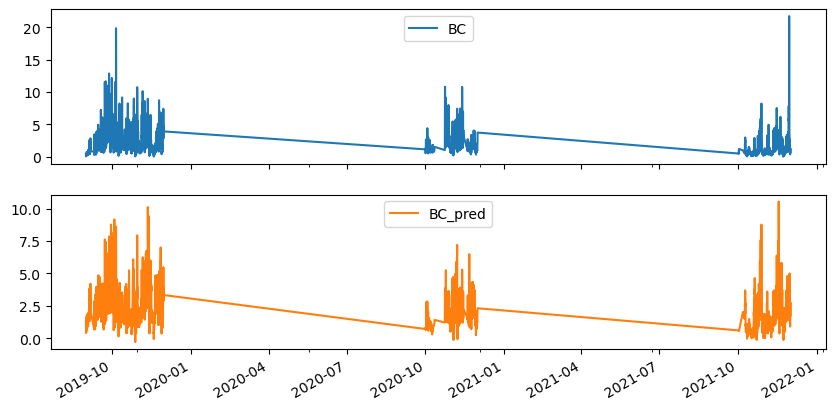

In [19]:
df = df.dropna()
# from sklearn.impute import SimpleImputer
# import numpy as np

# # Impute missing values with mean
# imp = SimpleImputer(missing_values=np.nan, strategy='mean')
# df.iloc[:, 0:9] = imp.fit_transform(df.iloc[:, 0:9])

from sklearn import linear_model
from scipy.stats import pearsonr
from matplotlib import pyplot as plt

# Filter data into 4 seasons
df['month'] = df.index.month
df['season'] = df['month'].apply(lambda x: 'DJF' if x in [12, 1, 2] else 'MAM' if x in [3, 4, 5] else 'JJA' if x in [6, 7, 8] else 'SON')

def calculate_regression(df, season):
    # df = df[df['season'] == season]
    X = df[['prec', 'wspd', 'temp', 'PM2.5']]
    y = df['BC']
    regr = linear_model.LinearRegression()
    regr = regr.fit(X, y)
    print(regr.coef_)
    df['BC_pred'] = regr.predict(X)
    
    plot_cols = ['BC', 'BC_pred']
    # fig, ax = plt.subplots(1,2, figsize=(10,5))
    df[plot_cols].plot(subplots=True, figsize=(10,5))
    print(pearsonr(df['BC'], df['BC_pred']))


    # Calculate pearson correlation of each variable in X with y
    # for col in X.columns:
    #     print(col, pearsonr(X[col], y))
    
    # Calculate R2
    # print("R2:", regr.score(X, y))

for season in df['season'].unique():
    print(season)
    calculate_regression(df, season)



